## Imports

In [1]:
import cv2
import glob
import numpy as np
import pickle as pkl
from tqdm import tqdm
import matching_utils
from eval_utils import *
import matplotlib.pyplot as plt

model = matching_utils.get_metric_learning_model()

Using cache found in /home/group05/.cache/torch/hub/pytorch_vision_v0.10.0


## Load detections

In [2]:
# Open the file in binary mode
seq = 'seq3'
cam = 'c10'

C = cam[0] + '0' + cam[1:]
S = 'S0' + seq[-1]

theshold = 0.28

with open(f'/home/group05/mcv-m6-2022-team5/week5/tracking_results/kalman_tracking_{seq}_{cam}_pp.pkl', 'rb') as file:
    # Call load method to deserialze
    detections = pkl.load(file)

video_path = f'/home/group05/mcv-m6-2022-team5/datasets/aic19-track1-mtmc-train/train/{S}/{C}/vdo.avi'

In [3]:
track_ids_df = matching_utils.init_global_track_ids_df()

# Detections to global df

In [ ]:
vidcap = cv2.VideoCapture(video_path)

_, _ = vidcap.read()

for detection in tqdm(detections):
    _, image = vidcap.read()
    if type(image) != type(None):
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        for index, row in detection.iterrows():
            if not row['track'] in track_ids_df['track_ids'].unique():
                track_ids_df = matching_utils.add_global_track_ids(track_ids_df, image, row)
            else:
                img = matching_utils.get_detected_box_image(image, row['bbox'])

                index = track_ids_df.index[track_ids_df['track_ids'] == row['track']].tolist()[0]
                detection_frames_list = track_ids_df.loc[index, 'detection_frames']

                distances = []

                for detection_frame in detection_frames_list:
                    distances.append(matching_utils.get_metric_distance(model, img, detection_frame)[0][1])

                if min(distances) > theshold:
                    track_ids_df = matching_utils.update_global_track_id(track_ids_df, image, row)

pkl.dump(track_ids_df, open(f"./matching_results/track_ids_df_{S}_{C}.pkl", "wb"))

In [56]:
with open(f"./matching_results/track_ids_df_{S}_{C}.pkl",'rb') as openFile:
    track_ids_df = pkl.load(openFile)

track_ids_df

,track_ids,detection_frames,old_track_ids
0,69,"[[[[133 127 118], [59 53 44], [109 103 94], [...",69
1,43,"[[[[162 174 170], [162 174 170], [162 174 170]...",92
2,67,"[[[[164 164 164], [161 161 161], [160 160 160]...",84
3,71,"[[[[45 53 60], [55 63 70], [71 79 86], [61 69 ...",15


1


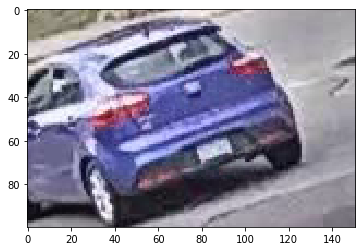

In [110]:
index = 2
print(len(track_ids_df.loc[index,'detection_frames']))
plt.imshow(track_ids_df.loc[index,'detection_frames'][0])
plt.show()

# Global Matching

In [5]:
def get_new_track_id(detections_pd):
    counter = 0

    while counter in detections_pd['track'].tolist():
        counter = counter + 1
    return counter

In [6]:
track_paths = '/home/group05/mcv-m6-2022-team5/week5/matching_results/track_ids_df*'
dfs = []

# load data
for file_name in glob.glob(track_paths):
    with open(file_name,'rb') as openFile:
        track_ids_df = pkl.load(openFile)
        track_ids_df['old_track_ids'] = track_ids_df['track_ids']
        dfs.append(track_ids_df)

global_track_ids_df = dfs[0]

In [9]:
for i in range(1,6):
    print('Processing camera ', i)
    drop_list = []
    counter = 0

    ## itr through cam i
    for index, row in dfs[i].iterrows():

        detection_frames_list = row['detection_frames']
        distance_min = []
        ## compare with anchor
        for index2, row2 in global_track_ids_df.iterrows():

            distances = []
            detection_frames_list2 = row2['detection_frames']
            for detection_frame in detection_frames_list:
                for detection_frame2 in detection_frames_list2:
                    distances.append(matching_utils.get_metric_distance(model, detection_frame2, detection_frame)[0][1])

            # print(f'Track: {row["track_ids"]} - {index2}, distance:{min(distances)}')
            distance_min.append(min(distances))

        ## taking only the minimum
        min_index = np.argmin(distance_min)
        if  distance_min[min_index] < 0.24:

            # print('matched at:', index, min_index)
            detection_frames = global_track_ids_df.at[min_index, 'detection_frames']
            detection_frames = detection_frames + detection_frames_list
            global_track_ids_df.at[min_index, 'detection_frames'] = detection_frames

            dfs[i].at[index, 'track_ids'] = global_track_ids_df.loc[min_index, 'track_ids']

            drop_list.append(index)

        else: 
            while counter in global_track_ids_df['track_ids'].tolist():
                counter = counter + 1
            dfs[i].at[index, 'track_ids'] = counter
            counter = counter + 1
            
    new_tracks = dfs[i].drop(index=drop_list)
    new_tracks.reset_index(drop=True, inplace = True)

    global_track_ids_df = global_track_ids_df.append(new_tracks)
    global_track_ids_df.reset_index(drop=True, inplace = True)

    dfs[i] = dfs[i].drop(columns='detection_frames')

dfs[0] = dfs[0].drop(columns='detection_frames')

Processing camera  1
Processing camera  2
Processing camera  3
Processing camera  4
Processing camera  5


In [10]:
pkl.dump(global_track_ids_df, open("matching_results/global_track_ids_df.pkl", "wb"))
pkl.dump(dfs, open("matching_results/dfs.pkl", "wb"))

## Update existing detections

In [3]:
with open("./matching_results/global_track_ids_df.pkl", 'rb') as file:
    global_track_ids_df = pkl.load(file)

with open("./matching_results/dfs.pkl", 'rb') as file:
    dfs = pkl.load(file)

In [4]:
gt_detect_path = '/home/group05/mcv-m6-2022-team5/week5/cam_pred_gt/seq3_*_gt.pkl'

all_gt_detections = []

# load gt
for file_name in sorted(glob.glob(gt_detect_path)):
    with open(file_name,'rb') as openFile:
        gt_detections = pkl.load(openFile)
        # print(gt_detections)
        all_gt_detections.append(gt_detections)

In [5]:
## load all detections to list
path  = '/home/group05/mcv-m6-2022-team5/week5/tracking_results/kalman_tracking_seq3_*_pp.pkl'
detections_list = []

# load data
for file_name in sorted(glob.glob(path)):
    with open(file_name,'rb') as openFile:
        detections = pkl.load(openFile)
        detections_list.append(detections)

In [6]:
import copy
detection_list_copy = copy.deepcopy(detections_list)

In [18]:
## update track ids to globl ids
for index, detections in enumerate(detections_list):
    for detection in tqdm(detections):
        for i, row in dfs[index].iterrows():
            detection.loc[detection['track'] == row['old_track_ids'], 'track'] = row['track_ids']

100%|██████████| 1928/1928 [00:03<00:00, 544.00it/s]


In [8]:
all_detections = []
for det in detections_list:
    all_detections.append(det)

In [6]:
all_detections_aux = []
for det in detection_list_copy:
    all_detections_aux.extend(det)

## Evaluate

In [23]:
det_copy2 = copy.deepcopy(detections_list)

In [26]:
tracks_per_camera = []
for ind in range(len(detections_list)):
    detectts = [el for df in detections_list[ind] for el in df['track'].tolist()] #tracks per camera
    tracks_per_camera.extend(np.unique(detectts)) #unique tracks per camera

tracks_to_delete, counts = np.unique(tracks_per_camera, return_counts=True) # count repeted tracks

result = list(filter(lambda x: x[1] == 1, np.column_stack((tracks_to_delete, counts))))
result = [x[0] for x in result] # get tracks with count 1 (only in one camera)


In [ ]:
len(tracks_per_camera)

In [24]:
ereased = 0
for ind in range(len(detections_list)): #iterate over cameras
    for frame in tqdm(range(len(detections_list[ind]))): # iterate over camera frames
        for track in result: #iterate over tacks to remove
            ereased += len(detections_list[ind][frame][detections_list[ind][frame]['track'] == track])
            detections_list[ind][frame] = detections_list[ind][frame][detections_list[ind][frame]['track'] != track] #remove tracks

ereased

100%|██████████| 2141/2141 [01:14<00:00, 28.69it/s]


1260

In [ ]:
det_copy2[1][1100]

,frame,track,bbox,colour,size,detection,life,initial_position_x,initial_position_y,static
1,Frame 1100,28,"[816, 708, 1017, 827]","[230, 123, 254]",23919,"Frame 1100, TL [816,708], BR [1017,827], Confi...",1101,743.0,678.0,False
4,Frame 1100,49,"[1065, 1129, 1670, 1404]","[103, 134, 210]",166375,"Frame 1100, TL [1065,1129], BR [1670,1404], Co...",21,2357.0,1615.0,False


In [25]:
## total frame count for seq3 => 13517
frames_per_video = [2141,2279,2422,2415,2332,1928]
acc = create_accumulator()
acum = 0
for ind, frames in enumerate(frames_per_video):
    for frame in tqdm(range(0, frames)):
        det_copy2[ind][frame] = det_copy2[ind][frame][det_copy2[ind][frame]['life'] != -1]
        gt_detections = all_gt_detections[ind]
        acc, frame_id = tracking_acc(frame, gt_detections, det_copy2[ind], acc, max_iou=1)
    acum += frames

print(f'{S} results:')
display_metrics(acc)

100%|██████████| 1928/1928 [00:01<00:00, 1120.48it/s]


S03 results:
     num_frames  precision    recall       idp       idr      idf1
acc       13517   0.740082  0.586168  0.414692  0.311791  0.347975


In [ ]:
## total frame count for seq3 => 13517

frames_per_video = [2141,2279,2422,2415,2332,1928]
acc = create_accumulator()
acum = 0
for ind, frames in enumerate(frames_per_video):
    for frame in tqdm(range(0, frames)):
        all_detections[acum + frame] = all_detections[acum + frame][all_detections[acum + frame]['life'] != -1]
        gt_detections = all_gt_detections[ind]
        acc, frame_id = tracking_acc(frame, gt_detections, all_detections, acc, max_iou=1)
    acum += frames

print(f'{S} results:')
display_metrics(acc)